In [1]:
#@title connect google drive 
from google.colab import drive
import numpy as np
import os


drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/GSoC/Evaluation")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#@title Import libraries
!pip install torch torchvision torchaudio --upgrade
!pip install fastai --upgrade
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from fastai.metrics import mse
from fastai.callback import schedule
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

  Using cached https://files.pythonhosted.org/packages/94/99/5861239a6e1ffe66e120f114a4d67e96e5c4b17c1a785dfc6ca6769585fc/torch-1.8.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6f/6a/4e8d7c897f24a6aa9d5e7c23a157b52084ccd43d1b6019603361d2136dde/torchvision-0.9.0-cp37-cp37m-manylinux1_x86_64.whl
Requirement already up-to-date: torchaudio in /usr/local/lib/python3.7/dist-packages (0.8.0)
ERROR: fastai 2.2.7 has requirement torch<1.8,>=1.7.0, but you'll have torch 1.8.0 which is incompatible.
ERROR: fastai 2.2.7 has requirement torchvision<0.9,>=0.8, but you'll have torchvision 0.9.0 which is incompatible.
  Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2
Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.2.7)
  Usin

In [3]:
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Read Data

As the dataset has a variable number of jets in each row, i decided to read every line, and extract all 4D momentum data of each jet and collect them in a numpy array with shape (N_JETS, 4)

In [4]:
with open("monojet_Zp2000.0_DM_50.0_chan3.csv", 'r') as csv_file: 
  lines_dataset = csv_file.readlines() # Reading csv file and get all lines

In [5]:
X = []
for line in lines_dataset: 
  event = line.split(";") # taking each line and spliting by ';'
  jets_ = []
  for item in event:
    if item.startswith("j,"): # Each jet momentum will be save in the dataset array, otherwise will ignore
      jets_  = jets_ + [item[2:].split(",")] 
  X = X + jets_


dataset = np.array(X, dtype=float) # Encapsuling in numpy array


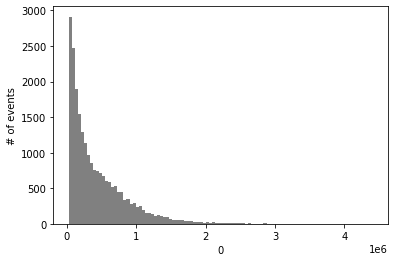

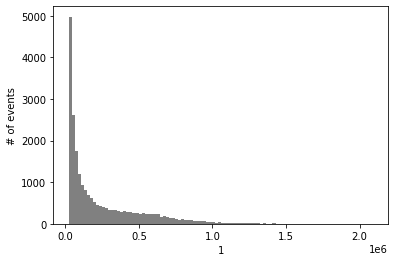

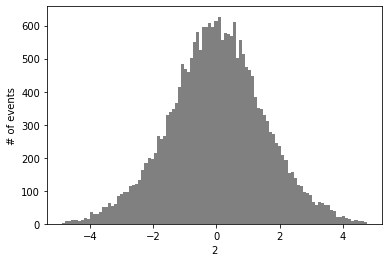

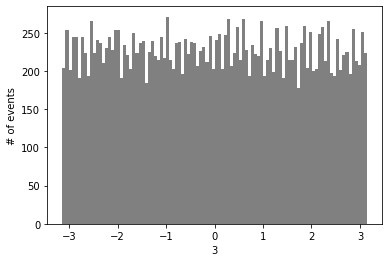

In [6]:
#@title Plot histogram of original data
n_bins = 100
#df = pd.DataFrame(dataset, dtype = float)
for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(dataset[:,kk], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=str(kk))
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

## Train test split dataset

In [7]:
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=42)  # Train and test division for comparing proposes

## Normalizing data

I'm going to experiment with two different normalizations implemented in the scikit-learn library 


*   [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
*   [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


The report of the results is at the final of the notebook


In [8]:
scaler_min_max = MinMaxScaler() # To scale data
X_train_scaled_min_max = scaler_min_max.fit_transform(X_train) # Fit with train data
X_test_scaled_min_max = scaler_min_max.transform(X_test) # Transform the test data

scaler_standar = StandardScaler() # To scale data
X_train_scaled_standar = scaler_standar.fit_transform(X_train) # Fit with train data
X_test_scaled_standar = scaler_standar.transform(X_test) # Transform the test data

In [9]:
def get_TensorDatasets(X_train_scaled, X_test_scaled):
  # Constructs a tensor object of the data and wraps them in a TensorDataset object.
  train_x = X_train_scaled
  train_y = X_train_scaled
  test_x = X_test_scaled
  test_y = X_test_scaled

  train_ds = TensorDataset(torch.tensor(train_x, dtype=torch.float), torch.tensor(train_y, dtype=torch.float))
  valid_ds = TensorDataset(torch.tensor(test_x, dtype=torch.float), torch.tensor(test_y, dtype=torch.float))

  return train_ds,valid_ds

train_ds_minmax,valid_ds_minmax = get_TensorDatasets(X_train_scaled_min_max, X_test_scaled_min_max)
train_ds_standar,valid_ds_standar = get_TensorDatasets(X_train_scaled_standar, X_test_scaled_standar)

In [10]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl_minmax = DataLoader(train_ds_minmax, batch_size=bs, shuffle=True)
valid_dl_minmax = DataLoader(valid_ds_minmax, batch_size=bs * 2)
dls_minmax = core.DataLoaders(train_dl_minmax, valid_dl_minmax)

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl_standar = DataLoader(train_ds_standar, batch_size=bs, shuffle=True)
valid_dl_standar = DataLoader(valid_ds_standar, batch_size=bs * 2)
dls_standar = core.DataLoaders(train_dl_standar, valid_dl_standar)

In [11]:
# Autoencoder model
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.leaky_realu = nn.LeakyReLU(0.1)

    def encode(self, x):
        return self.en4(self.leaky_realu(self.en3(self.leaky_realu(self.en2(self.leaky_realu(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.leaky_realu(self.de3(self.leaky_realu(self.de2(self.leaky_realu(self.de1(self.leaky_realu(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'


## Training with the train data using standard normalization

In [12]:
#@title Model used 
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (leaky_realu): LeakyReLU(negative_slope=0.1)
)

In [13]:
loss_func = nn.MSELoss()
wd = 1e-6
recorder = learner.Recorder()
learn = learner.Learner(dls_standar, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Learning rate with the minimum loss: 0.003981071710586548
Learning rate with the steepest gradient: 0.002511886414140463


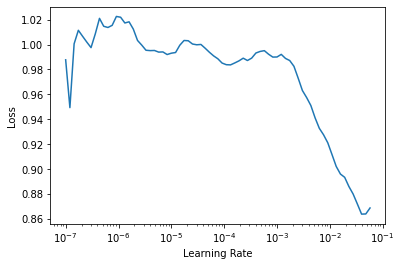

In [14]:
#@title finding learning rate optimum
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [15]:
#@title Train
start = time.perf_counter() # Starts timer
learn.fit(n_epoch=100, lr=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.35499265789985657, 0.18342262506484985, '00:00']
[0, 0.35499265789985657, 0.18342262506484985, '00:00']
[1, 0.11452358961105347, 0.022296765819191933, '00:00']
[1, 0.11452358961105347, 0.022296765819191933, '00:00']
[2, 0.03303249180316925, 0.0053518968634307384, '00:00']
[2, 0.03303249180316925, 0.0053518968634307384, '00:00']
[3, 0.013099930249154568, 0.002651549642905593, '00:00']
[3, 0.013099930249154568, 0.002651549642905593, '00:00']
[4, 0.004703981336206198, 0.002176332985982299, '00:00']
[4, 0.004703981336206198, 0.002176332985982299, '00:00']
[5, 0.0026211626827716827, 0.001462200772948563, '00:00']
[5, 0.0026211626827716827, 0.001462200772948563, '00:00']
[6, 0.002843213500455022, 0.0033280260395258665, '00:00']
[6, 0.002843213500455022, 0.0033280260395258665, '00:00']
[7, 0.001987919444218278, 0.0017372380243614316, '00:00']
[7, 0.001987919444218278, 0.0017372380243614316, '00:00']
[8, 0.0017524491995573044, 0.0018450915813446045, '00:00']
[8, 0.0017524491995573044, 0.

Validation MSE [0.000380279088858515]


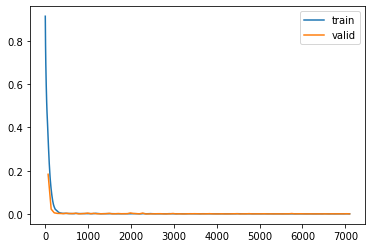

In [16]:
#@title loss vs epochs
recorder.plot_loss()

print("Validation MSE", learn.validate())

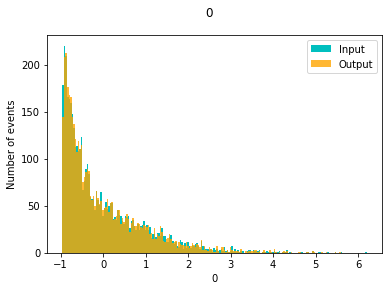

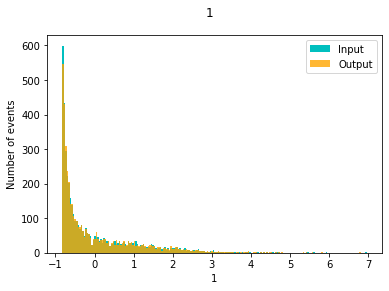

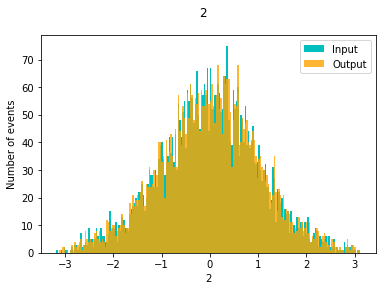

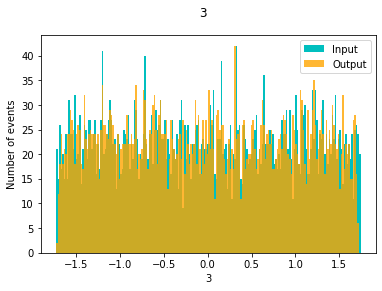

In [17]:
#@title Histogram comparision between test set and predictions(STANDARD)

def histogram_comparision(x_test,title):

  colors = ['orange', 'c']
  markers = ['*', 's']
  model.to('cpu')

  save = True # Option to save figure

  data = torch.tensor(x_test, dtype=torch.float)

  pred = model(data)
  pred = pred.detach().numpy()
  data = data.detach().numpy()

  alph = 0.8
  n_bins = 200
  for kk in np.arange(4):
      plt.figure()
      n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
      n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
      plt.suptitle(str(kk))
      plt.xlabel(str(kk))
      plt.ylabel('Number of events')
      plt.legend()
      if save:
          plt.savefig(os.path.join(save_dir,"Hist_"+str(kk)+title+'.png'))
      


x_test = X_test_scaled_standar
title = "Standar_normalization"
histogram_comparision(x_test,title)

In [18]:
#@title Function to calculate MSE of each element in the 4D mementum
def calculate_mse_column(data, pred, title): 
  
  errors = np.zeros(data.shape[1])
  for i in range(data.shape[1]):
    errors[i] = mean_squared_error(data[:,i], pred[:,i])

  fig = plt.figure()

  x = [str(i) for i in range(data.shape[1])]
  plt.bar(x,errors)
  plt.xlabel("Column")
  plt.ylabel('MSE')
  plt.title(title)
  fig.show()
  fig.savefig(os.path.join(save_dir, title +".png"))


In [19]:
#@title Function to calculate PSNR of each element in the 4D mementum
import math 
def calculate_psnr_column(data, pred, title): 
  
  psnr = np.zeros(data.shape[1])
  for i in range(data.shape[1]):
    range_value = data[:,i].max() - data[:,i].min()
    mse = mean_squared_error(data[:,i], pred[:,i])

    psnr[i] = 20 * math.log10(range_value / math.sqrt(mse)) 

  fig = plt.figure()

  x = [str(i) for i in range(data.shape[1])]
  plt.bar(x,psnr)
  plt.xlabel("Column")
  plt.ylabel('PSNR')
  plt.title(title)
  fig.show()
  fig.savefig(os.path.join(save_dir, title +".png"))


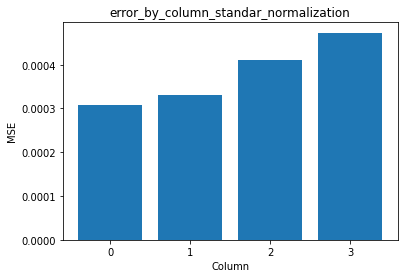

In [20]:
#@title  MSE by column with standard normalized test

data = torch.tensor(X_test_scaled_standar, dtype=torch.float)

pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

calculate_mse_column(data, pred, 'error_by_column_standard_normalization')

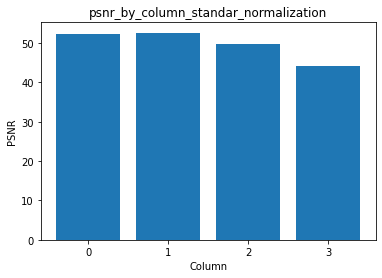

In [21]:
#@title  PSNR by column with standar normalized test

data = torch.tensor(X_test_scaled_standar, dtype=torch.float)

pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

calculate_psnr_column(data, pred, 'psnr_by_column_standard_normalization')

## Training with the train data using MinMax normalization

In [22]:
#@title Model Used
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (leaky_realu): LeakyReLU(negative_slope=0.1)
)

In [23]:
loss_func = nn.MSELoss()
wd = 1e-6
recorder = learner.Recorder()
learn = learner.Learner(dls_minmax, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Learning rate with the minimum loss: 0.005754399299621582
Learning rate with the steepest gradient: 0.0010000000474974513


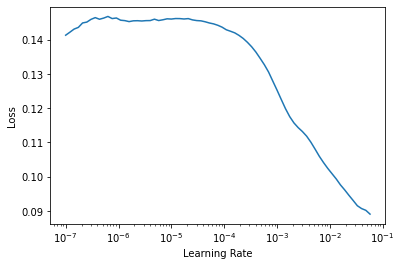

In [24]:
#@title finding learning rate optimum
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [25]:
#@title Train
start = time.perf_counter() # Starts timer
learn.fit(n_epoch=100, lr=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.016323482617735863, 0.007069665007293224, '00:00']
[0, 0.016323482617735863, 0.007069665007293224, '00:00']
[1, 0.00828296598047018, 0.005946172401309013, '00:00']
[1, 0.00828296598047018, 0.005946172401309013, '00:00']
[2, 0.006573913618922234, 0.005829688627272844, '00:00']
[2, 0.006573913618922234, 0.005829688627272844, '00:00']
[3, 0.0060493522323668, 0.005835482385009527, '00:00']
[3, 0.0060493522323668, 0.005835482385009527, '00:00']
[4, 0.005490574520081282, 0.0048639471642673016, '00:00']
[4, 0.005490574520081282, 0.0048639471642673016, '00:00']
[5, 0.0035388099495321512, 0.001060543698258698, '00:00']
[5, 0.0035388099495321512, 0.001060543698258698, '00:00']
[6, 0.001153023331426084, 0.00013672554632648826, '00:00']
[6, 0.001153023331426084, 0.00013672554632648826, '00:00']
[7, 0.0003747215087059885, 0.00018312709289602935, '00:00']
[7, 0.0003747215087059885, 0.00018312709289602935, '00:00']
[8, 0.0001897753681987524, 6.869290518807247e-05, '00:00']
[8, 0.000189775368198

Validation MSE [7.417145752697252e-06]


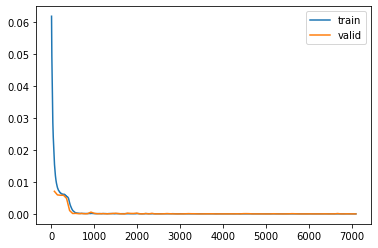

In [26]:
#@title loss vs epochs
recorder.plot_loss()

print("Validation MSE", learn.validate())

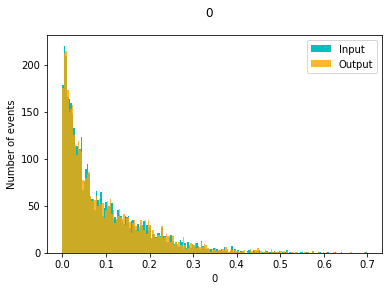

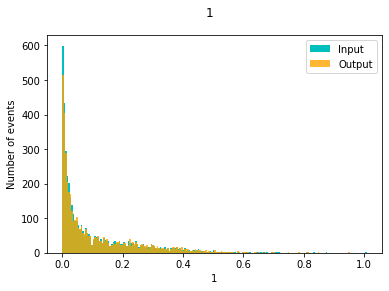

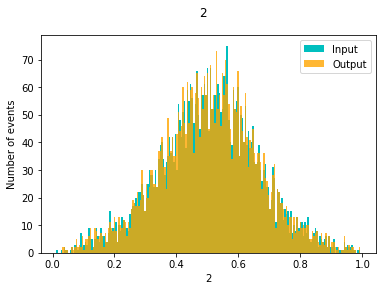

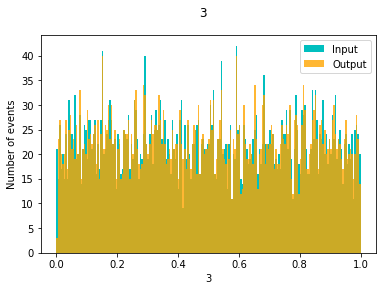

In [27]:
#@title Histogram comparision between test set and predictions(MinMax)

x_test = X_test_scaled_min_max
title = "MinMax_normalization"
histogram_comparision(x_test,title)

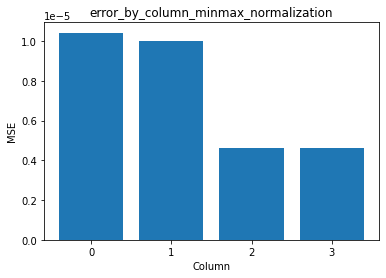

In [28]:
#@title MSE by column with MinMax normalized test
data = torch.tensor(X_test_scaled_min_max, dtype=torch.float)

pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

calculate_mse_column(data, pred, 'error_by_column_minmax_normalization')

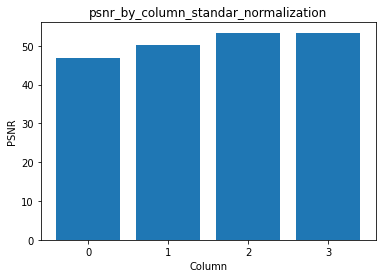

In [29]:
#@title  PSNR by column with MinMax normalized test

data = torch.tensor(X_test_scaled_min_max, dtype=torch.float)

pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

calculate_psnr_column(data, pred, 'psnr_by_column_minmax_normalization')

## Summary & Conclusions



*   This notebook consists in the implementation of the first evaluation process to apply in the Deep autoencoders data compression in ATLAS 
*   An autoencoder to compress the four-momentum of a sample of simulated particles from 4 to 3 variables was successfully implemented.
*   Two different methods to normalized data was evaluated in order to achieve better results.

